# Notebook 2: Creating, saving and reading projections and slices

This script shows how to

- make projections and slices
- save them as an ArepoImage
- read the ArepoImage to plot the data
- use Paicos to deal with units and help with plotting


## Making projections

We now use the Paicos projector classes. There are multiple projectors:

- `Projector` which creates an image of a given variable by projecting it onto a 2D plane.
- `TreeProjector` which creates an image of a given variable by projecting the voronoi cells closest to the line of sight using a KDTree.
- `GphSphProjector` (see Notebook 5) which creates an image of a given variable by projecting it onto a 2D plane.
- `GpuRayProjector` (see Notebook 6) which creates an image of a given variable by projecting it onto a 2D plane. This class works by raytracing the variable(i.e. by calculating a line integral along the line-of-sight).

**To find out how to project non-gas particle types, go to the *examples/projector_nongas_example.py* in the repository.**


### Projector Class

Here we start by using the SPH projector class called `Projector`.

We use the `widths` vector is the size of the considered box in x,y,z coordinates. This box is centered at `center` vector.

The `direction` can be set to 'x', 'y' or 'z'. If the direction is 'z' (as below) then widths[2] is the depth of the projection and the 2D returned array is in the xy plane.

`npix` is the number of pixels in the horizontal direction of the image. The width/height ratio should be such that
$$npix*height/width$$
is an integer, such that the image pixels are square.

In [1]:
import paicos as pa
import numpy as np

# A snapshot object
snap = pa.Snapshot(pa.data_dir, 247)

# The center of the most massive Friends-of-friends group in the simulation
center = snap.Cat.Group['GroupPos'][0]

In [2]:
# The widths of the subbox to be projected
widths = [26000, 13000, 10000]

# Create a projector object
projector = pa.Projector(snap, center, widths, 'z', npix=2048)

# Let's look at its docstring
projector?

Attempting to get derived variable: 0_Volume...	[DONE]



Type:           Projector
String form:    <paicos.image_creators.projector.Projector object at 0x7f20f0793bb0>
File:           ~/analysis/paicos/paicos/image_creators/projector.py
Docstring:     
A class that allows creating an image of a given variable by projecting
it onto a 2D plane.

The Projector class is a subclass of the ImageCreator class.
The Projector class creates an image of a given variable by projecting
it onto a 2D plane.

It takes in several parameters such as a snapshot object, center and
widths of the region, direction of projection, and various optional
parameters for number of pixels, smoothing length.
Init docstring:
Initialize the Projector class.

Parameters
----------
snap : Snapshot
    A snapshot object of Snapshot class from paicos package.

center : numpy array
    Center of the region on which projection is to be done, e.g.
    center = [x_c, y_c, z_c].

widths : numpy array
    Widths of the region on which projection is to be done,
    e.g.m widths=[width

#### Calling project_variable
We can call the `project_variable` method as below. This method can take a number of standard strings (which then internally calls the get_variable function, see further details below) or it can take an array. Both methods are shown below.

In [3]:
Masses = projector.project_variable('0_Masses')
Volumes = projector.project_variable(snap['0_Volume'])
rho = Masses/Volumes

rho

Attempting to get derived variable: 0_Volume...	[DONE]



<PaicosQuantity [[5.97826609e-10, 5.98904216e-10, 5.99944873e-10, ...,
                  2.74327529e-09, 2.72723099e-09, 2.70893193e-09],
                 [5.99086484e-10, 6.00146927e-10, 6.01168837e-10, ...,
                  2.75638145e-09, 2.74090042e-09, 2.72323553e-09],
                 [6.00303730e-10, 6.01347285e-10, 6.02351306e-10, ...,
                  2.76934974e-09, 2.75277902e-09, 2.73567615e-09],
                 ...,
                 [2.68398067e-09, 2.69577298e-09, 2.70587085e-09, ...,
                  1.04739363e-09, 1.04956438e-09, 1.05179782e-09],
                 [2.67791900e-09, 2.69019352e-09, 2.70069908e-09, ...,
                  1.05066476e-09, 1.05288808e-09, 1.05517628e-09],
                 [2.67089558e-09, 2.68372597e-09, 2.69470154e-09, ...,
                  1.05405620e-09, 1.05633479e-09, 1.05868058e-09]] arepo_density small_h2 / small_a3>

The projector object contains a number of useful attributes with mostly self-explanatory names:

In [4]:
# Widths (same as user input)
projector.widths

# Volume of the subbox
projector.volume

# Area per pixel
projector.area_per_pixel

# Volume per pixel
projector.volume_per_pixel

# Center of the image (same as user input)
projector.center

# Depth of the projection
projector.depth

# Height of the image (i.e. along the vertical direction of the image)
projector.height

# Width of the image (i.e. along the horizontal direction of the image)
projector.width

# For use in the matplotlib argument extent
projector.extent

# For centering the image such that its center is at (0, 0).
projector.centered_extent 


<PaicosQuantity [-13000.,  13000.,  -6500.,   6500.] arepo_length small_a / small_h>

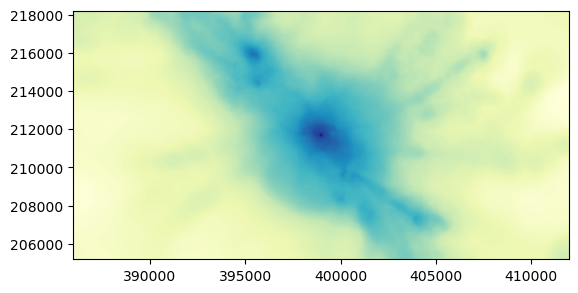

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('image', origin='lower', cmap='RdBu_r', interpolation='None')
plt.imshow(rho.value, cmap='YlGnBu', extent=projector.extent.value, norm=LogNorm())

### TreeProjector Class

Here we introduce the `TreeProjector` class. We use similar parameters as for the previous projector class.

However, we can now choose:
- `npix_depth` is the number of pixels in the depth direction, by default set automatically based on the smallest cell sizes in the region and the tolerance parameter, tol (see below).
- `tol` is the tolerance parameter: smaller values of tol adds more slices to the integration.

**NOTE: this projector takes a while to compute!**

Please have a look at the `examples` folder in the repository, specifically the file `tree_projector_example.py`.

If you have access to a GPU, you can use the Gpu projector classes!

## Making slices


**To find out how to make slices of non-gas particle types, go to the *examples/slicer_nongas_example.py* in the repository.**


Next, we will take a look at making a slice through the simulation. The width is by definition zero, and the user has to set this explicitly by setting a zero in the 'widths' vector. Below we show a slice of density, comparing with the projected density.

In [6]:
widths = [26000, 13000, 0]

slicer = pa.Slicer(snap, center, widths, 'z', npix=2048)

#### Calling slice_variable

<Figure size 640x480 with 0 Axes>

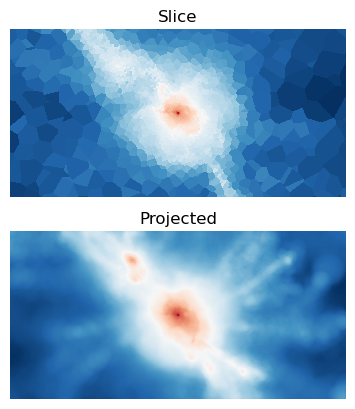

In [7]:
plt.figure(1)
plt.clf()
fix, axes = plt.subplots(nrows=2)

# Slice by passing an array
rho_slice = slicer.slice_variable(snap['0_Density'])

# Slice by passing a string (see snap.info(0) for the available strings)
rho_slice = slicer.slice_variable('0_Density')

# Now plot slice and projection next to each other
axes[0].imshow(rho_slice.to_physical.value, norm=LogNorm())
axes[1].imshow(rho.value, norm=LogNorm())
axes[0].set_title('Slice')
axes[1].set_title('Projected')
for ii in range(2):
    axes[ii].set_axis_off()
# plt.savefig('halo3_Z12_slice_projec_comparison.pdf', dpi=2000, bbox_inches='tight')

We can also make slices of other variables. The Slicer object stores the required information (indices of the Voronoi cells closest to the image grid points), so the computing time needed for making additional slices is neglibible.

Let us for instance consider the enstrophy which gives an indication of the amount of turbulence in the galaxy cluster.
It is defined as

1/2|∇×v|²

and can be found from the 'VelocityGradient' field (the 3x3 tensor of velocity derivatives, ∂ᵢvⱼ, which is stored in the example Arepo snapshot). This is done internally below:

Attempting to get derived variable: 0_Enstrophy...	[DONE]



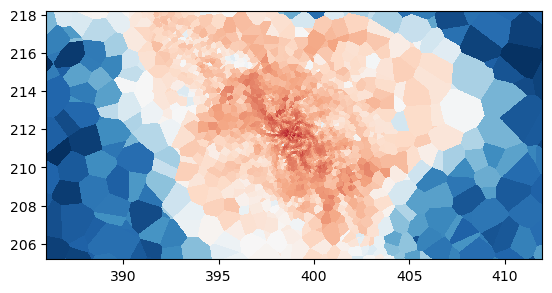

In [8]:
extent = slicer.extent.to('Mpc')

plt.imshow(slicer.slice_variable('0_Enstrophy').value,
           extent=extent.value,
           norm=LogNorm())

## Storing image data



The computing time for slices, and in particular, projections, is often quite long. It is therefore convenient to be able to store the image data so that this step is de-coupled from the often many matplotlib iterations.

Below we illustrate how to save an image using the `ArepoImage` class, created using either a `Projector` or `Slicer` object.

In [9]:
image_file = pa.ArepoImage(slicer, basedir=pa.data_dir,
                           basename='test_arepo_image_format')

image_file.save_image('Density', slicer.slice_variable('0_Density'))
image_file.save_image('Enstrophy', slicer.slice_variable('0_Enstrophy'))

image_file.finalize()

The constructed file is found at:

In [10]:
image_file.filename

'/home/lena/analysis/paicos/data/test_arepo_image_format_247.hdf5'

## Reading image data

Now let's open this image and look at its contents. We can use the `ImageReader` which is made to read additional info stored in image files: 

In [15]:
im = pa.ImageReader(basedir=pa.data_dir, snapnum=247, basename='test_arepo_image_format')
im.Config
im.Parameters
im.Header
# print(im['Density'])
# print(im['Enstrophy'])

{'BoxSize': 1000000.0,
 'Composition_vector_length': 0,
 'Flag_Cooling': 1,
 'Flag_DoublePrecision': 0,
 'Flag_Feedback': 1,
 'Flag_Metals': 0,
 'Flag_Sfr': 1,
 'Flag_StellarAge': 0,
 'Git_commit': b'660e0bd181b4dc2fc12eff19e19ec5048bd2fcdd',
 'Git_date': b'Sat May 22 19:44:26 2021 +0200',
 'HubbleParam': 0.6732117,
 'MassTable': array([   0.        ,    6.88707269,    0.        , 3526.18121889,
           0.        ,    0.        ]),
 'NumFilesPerSnapshot': 1,
 'NumPart_ThisFile': array([2172897,   72640,    7357, 2096682,       5,      83], dtype=int32),
 'NumPart_Total': array([2172897,   72640,    7357, 2096682,       5,      83], dtype=uint32),
 'NumPart_Total_HighWord': array([0, 0, 0, 0, 0, 0], dtype=uint32),
 'Omega0': 0.31582309,
 'OmegaBaryon': 0.04938682,
 'OmegaLambda': 0.68417691,
 'Redshift': 2.220446049250313e-16,
 'Time': 0.9999999999999998,
 'UnitLength_in_cm': 3.085678e+21,
 'UnitMass_in_g': 1.989e+43,
 'UnitVelocity_in_cm_per_s': 100000.0}

Here 'Config', 'Header', 'Parameters' are groups copied over from the snapshot file used to create the image (.0.hdf5 when there are multiple files).

'Density' and 'Enstrophy' are 2D arrays saved images.

We can also access information about the slice originally made:

In [16]:
print(im.direction)
print(im.center)
print(im.extent)
print(im.widths)
print(im.npix)

z
[398968.40625 211682.59375 629969.875  ] arepo_length small_a / small_h
[385968.40625 411968.40625 205182.59375 218182.59375] arepo_length small_a / small_h
[26000. 13000.     0.] arepo_length small_a / small_h
1024


We can of course also use hdf5 to access this information. Specifically, the image information is stored in 'image_info':

In [17]:
import h5py
f = h5py.File(image_file.filename, 'r')
print(list(f.keys()))
print(f['image_info'].keys())
print(f['image_info'].attrs.keys())

['Config', 'Density', 'Enstrophy', 'Header', 'Parameters', 'image_info', 'org_info']
<KeysViewHDF5 ['center', 'extent', 'widths']>
<KeysViewHDF5 ['direction', 'image_creator']>


All required unit information is also saved in the image file:

In [18]:
dict(f['Density'].attrs)

{'unit': 'arepo_density small_h2 / small_a3'}

## Advanced plotting and dealing with units

The advantage of using the `ImageReader` is that it helps with units!

We can use the ImageReader class to automatically get the image data in the form of PaicosQuantities (i.e. with units and in-built methods for manipulation). All the relevant information is stored in the image file, e.g.:

Text(0, 0.5, '$y\\;[\\mathrm{c}\\mathrm{Mpc}]$')

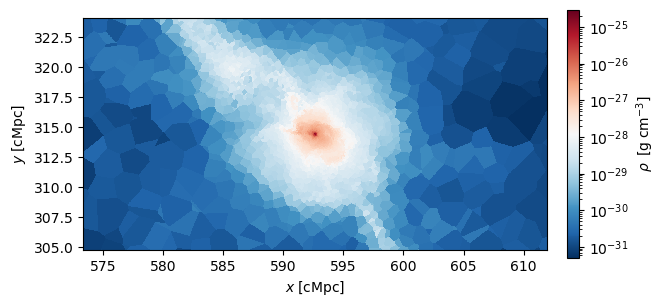

In [19]:

# Convert the extent to Mpc and get rid of the h factor
extent = im.extent.to('Mpc').no_small_h #.to_physical

# Get rid of both a and h in the density
rho = im['Density'].to_physical

# Convert rho to typical astro units
rho = rho.astro

# Convert rho to cgs
rho = rho.cgs

# Plot the image
image = plt.imshow(rho.value, extent=extent.value, norm=LogNorm())

# Add a colorbar
cbar = plt.colorbar(image, fraction=0.025, pad=0.04)

# Set the labels. The units for the labels are here set using the .label method
# of the PaicosQuantity. This internally uses astropy functionality and is
# mainly a convenience function.
cbar.set_label(rho.label('\\rho'))
plt.xlabel(extent.label('x'))
plt.ylabel(extent.label('y'))

#### Centering the projection

We can also easily center our projection so that the x and y scales are more easily readable:

Text(0, 0.5, '$y\\;[\\mathrm{c}\\mathrm{Mpc}]$')

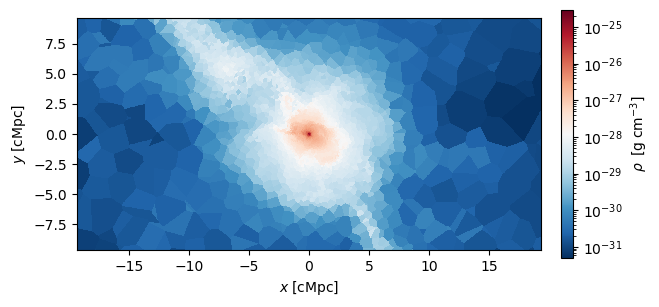

In [20]:

# Convert the extent to Mpc and get rid of the h factor
centered_extent = im.centered_extent.to('Mpc').no_small_h #.to_physical

image = plt.imshow(rho.value, extent=centered_extent.value, norm=LogNorm())

# Add a colorbar
cbar = plt.colorbar(image, fraction=0.025, pad=0.04)

# Set the labels. The units for the labels are here set using the .label method
# of the PaicosQuantity. This internally uses astropy functionality and is
# mainly a convenience function.
cbar.set_label(rho.label('\\rho'))
plt.xlabel(extent.label('x'))
plt.ylabel(extent.label('y'))